# This notebook focuses on the analysis of the premiums_rest (age > 25) dataset.

## Introduction

This document presents an end-to-end analysis and predictive modeling exercise on healthcare insurance premiums for individuals aged above 25. The objective is to understand key demographic, lifestyle, and medical factors influencing annual premium amounts and to build robust machine learning models capable of accurate premium prediction.

The analysis begins with extensive data cleaning and preprocessing, including handling missing values, correcting data inconsistencies, treating outliers, and standardizing categorical variables. Exploratory Data Analysis (EDA) is performed to uncover distributions, relationships, and patterns across numerical and categorical features. Feature engineering techniques—such as medical risk score construction, encoding of categorical variables, scaling, and multicollinearity checks—are applied to prepare the data for modeling.

Multiple regression and tree-based models, including Linear Regression, Ridge Regression, and XGBoost, are evaluated to identify the best-performing approach for premium prediction on the adult population subset.

In [1]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

In [2]:
# Loading the data
df= pd.read_excel('premiums_rest.xlsx')
df.head()

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,10L - 25L,14,Diabetes,Bronze,15610


In [3]:
# Number of rows and columns in the data
df.shape

(29904, 13)

In [4]:
# converting  all columns into consistent naming
df.columns = df.columns.str.replace(' ', '_' ).str.lower()
df.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,10L - 25L,14,Diabetes,Bronze,15610


In [5]:
# Finding null values
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           9
employment_status        1
income_level             9
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

In [6]:
# Dropping the null values
df.dropna(inplace=True)
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

In [7]:
# Finding duplicate values
df.duplicated().sum()

0

In [8]:
# Getting more information about the dataset
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,29886.000000,29886.000000,29886.000000,29886.000000
mean,43.396105,2.379910,23.364184,20892.303821
std,13.412657,1.431201,24.740339,6936.813440
min,26.000000,-3.000000,1.000000,3625.000000
25%,34.000000,1.000000,7.000000,15697.250000
50%,42.000000,3.000000,17.000000,20489.000000
75%,52.000000,3.000000,32.000000,26360.000000
max,356.000000,5.000000,930.000000,43471.000000


In [9]:
# Getting info about number of dependants which are negative values
df[df.number_of_dependants<0]['number_of_dependants'].unique()

array([-1, -3])

In [10]:
# Number of rows where number of dependants is less than zero
df[df.number_of_dependants<0].shape

(50, 13)

In [11]:
# Changing negative values of dependants positive
df['number_of_dependants'] = abs(df['number_of_dependants'])

In [12]:
# Getting more information about number of dependants
df['number_of_dependants'].describe()

count    29886.000000
mean         2.385933
std          1.421137
min          0.000000
25%          1.000000
50%          3.000000
75%          3.000000
max          5.000000
Name: number_of_dependants, dtype: float64

In [13]:
# finding the numerical columns
numeric_columns = df.select_dtypes(['float64', 'int64']).columns
numeric_columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount'], dtype='object')

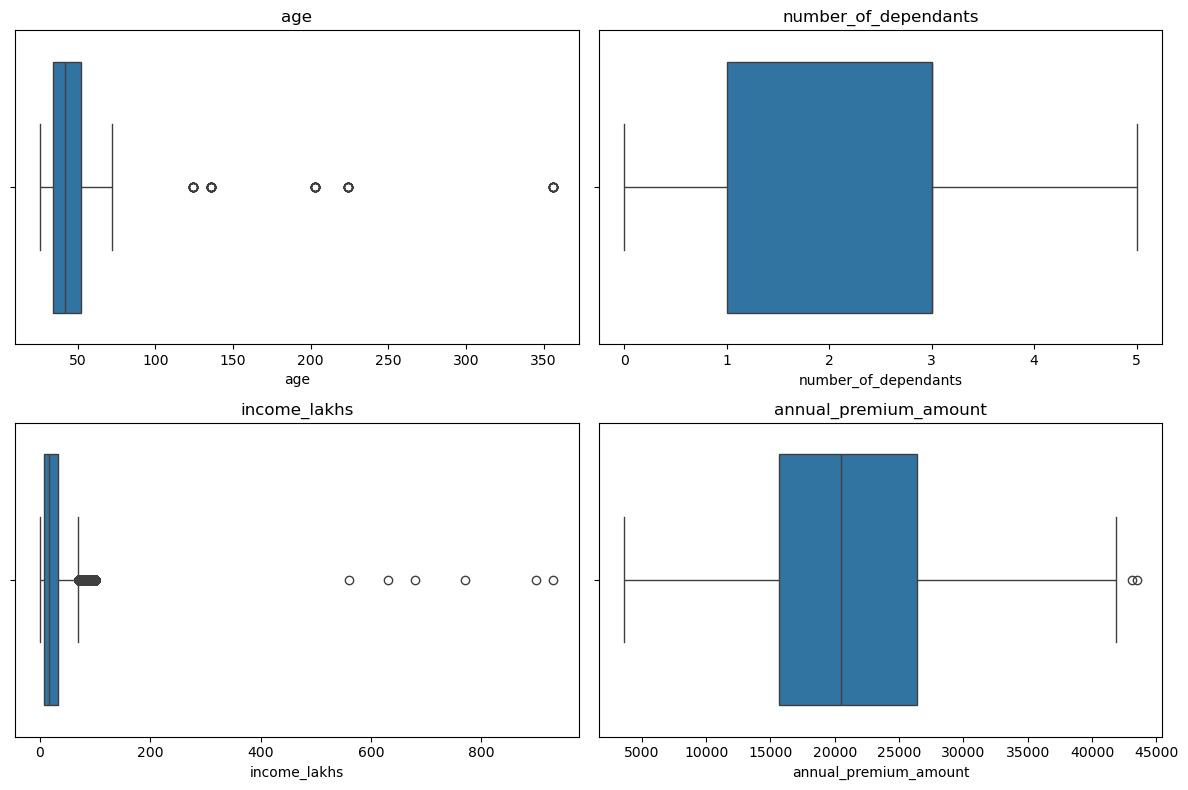

In [14]:
# Plotting the numerical column to check for outliers
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

axes = axes.flatten()   # flatten so we can index easily

for ax, col in zip(axes, numeric_columns[:4]):   # take first 4 columns
    sns.boxplot(x=df[col], ax=ax)
    ax.set_title(col)

plt.tight_layout()
plt.show()

The boxplots show that age and income_lakhs contain extreme outliers, indicating unusually large values. 
Annual premium amount has a few high outliers but is generally well-distributed. 
Number of dependants appears clean with no major anomalies.
Overall, the dataset needs outlier treatment, especially for age and income.

In [15]:
# Finding the rows where age is greater than 100
df[df.age>100]

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
77,224,Male,Northeast,Married,3,Normal,Regular,Salaried,25L - 40L,26,No Disease,Gold,27523
488,124,Female,Southwest,Unmarried,0,Normal,No Smoking,Freelancer,> 40L,46,No Disease,Silver,11752
803,124,Female,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,3,No Disease,Bronze,5311
902,124,Female,Southwest,Unmarried,1,Overweight,No Smoking,Salaried,<10L,2,Diabetes,Bronze,10238
912,136,Male,Southeast,Married,3,Overweight,Regular,Self-Employed,10L - 25L,15,High blood pressure,Gold,31913
1097,203,Female,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,<10L,6,Diabetes,Bronze,8762
2211,136,Male,Southwest,Married,2,Normal,Regular,Salaried,10L - 25L,20,Diabetes & Thyroid,Gold,31402
2556,203,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,18,No Disease,Bronze,5254
3426,124,Female,Southeast,Unmarried,1,Normal,No Smoking,Self-Employed,25L - 40L,29,No Disease,Silver,10265
3576,136,Male,Southwest,Married,3,Underweight,Regular,Self-Employed,<10L,2,Heart disease,Silver,26127


In [16]:
# finding uniques values of age over 100
df[df.age>100]['age'].unique()

array([224, 124, 136, 203, 356])

In [17]:
# Generating the dataset having age less or equal to 100
df1 = df[df.age<=100].copy()
df1.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,29828.000000,29828.000000,29828.000000,29828.000000
mean,43.095380,2.387790,23.371530,20901.900563
std,11.041991,1.420641,24.751262,6928.457636
min,26.000000,0.000000,1.000000,6538.000000
25%,34.000000,1.000000,7.000000,15706.000000
50%,42.000000,3.000000,17.000000,20496.000000
75%,52.000000,3.000000,32.000000,26361.000000
max,72.000000,5.000000,930.000000,43471.000000


<Axes: xlabel='income_lakhs', ylabel='Count'>

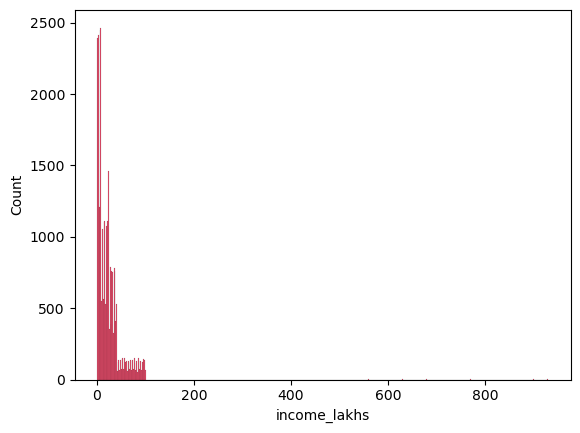

In [18]:
# plotting the income distribution
sns.histplot(df1.income_lakhs, color = 'crimson')

The histogram shows a highly right-skewed income distribution, where most individuals earn between 0–50 lakhs. A small number of extreme high-income values (up to 900+ lakhs) create a long right tail, compressing the main data to the left. This indicates the presence of significant outliers and large income inequality.

In [19]:
# Getting the quartile values for income
df1.income_lakhs.quantile([0.25, 0.75])

0.25     7.0
0.75    32.0
Name: income_lakhs, dtype: float64

In [20]:
# getting upper bound and lower bound of income values
def get_iqr_bounds(col):
    Q1, Q3 = col.quantile([0.25,0.75])
    IQR = Q3-Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 +1.5 * IQR
    return lower_bound, upper_bound

In [21]:
# Setting the income threshold
quantile_threshold = df1.income_lakhs.quantile(0.999)
quantile_threshold

100.0

In [22]:
# Finding the rows where income is greater than threshold value
df1[df1.income_lakhs > quantile_threshold].shape

(6, 13)

In [23]:
# getting the dataset where income is less than the income threshold value
df2 = df1[df1.income_lakhs <= quantile_threshold].copy()
df2.shape

(29822, 13)

In [24]:
# Getting information about the new dataset
df2.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,29822.000000,29822.000000,29822.000000,29822.000000
mean,43.094896,2.387734,23.226343,20900.689223
std,11.042430,1.420644,22.455408,6928.192115
min,26.000000,0.000000,1.000000,6538.000000
25%,34.000000,1.000000,7.000000,15705.250000
50%,42.000000,3.000000,17.000000,20495.500000
75%,52.000000,3.000000,32.000000,26360.000000
max,72.000000,5.000000,100.000000,43471.000000


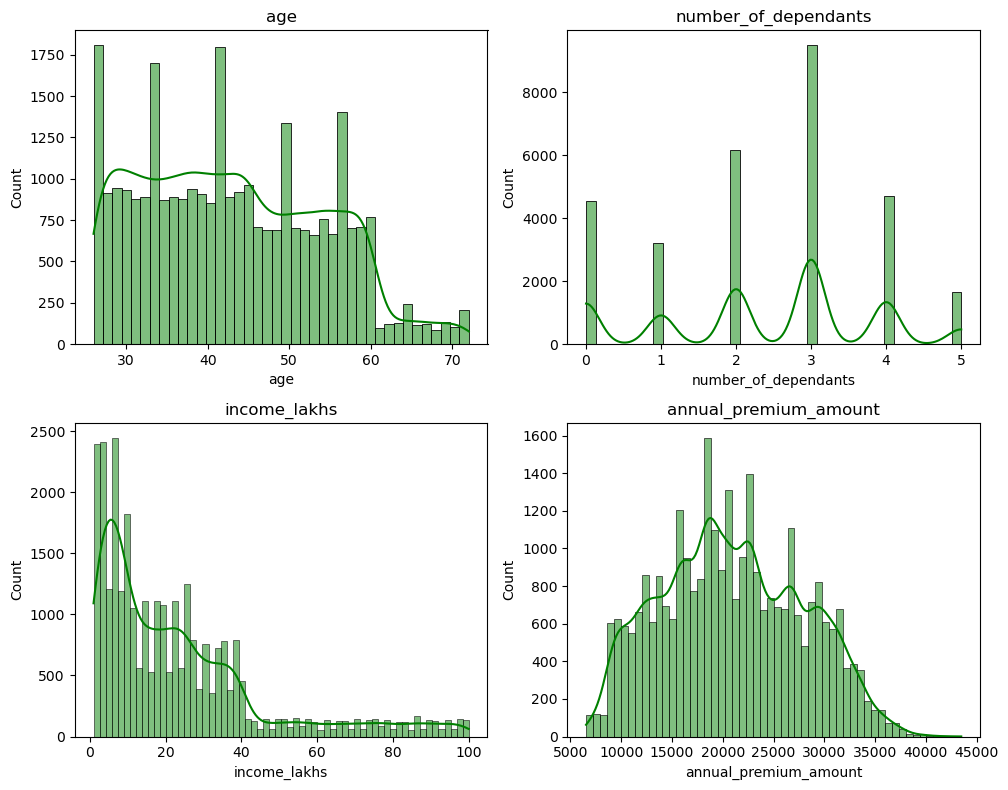

In [25]:
# Assume numeric_columns has 4 columns
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

axes = axes.flatten()

for ax, col in zip(axes, numeric_columns):
    sns.histplot(df2[col], kde=True, ax=ax,color='green')
    ax.set_title(col)

plt.tight_layout()
plt.show()

Age distribution is fairly uniform between 30–55, with fewer policyholders above 60.

Number of dependents shows peaks at 0, 2, and 3 dependents, suggesting these are the most common family sizes.

Income (lakhs) is right-skewed, meaning most customers earn below ~20 lakhs, with fewer high-income individuals.

Annual premium amount forms a broad bell-shaped curve, concentrated between 15,000–30,000.

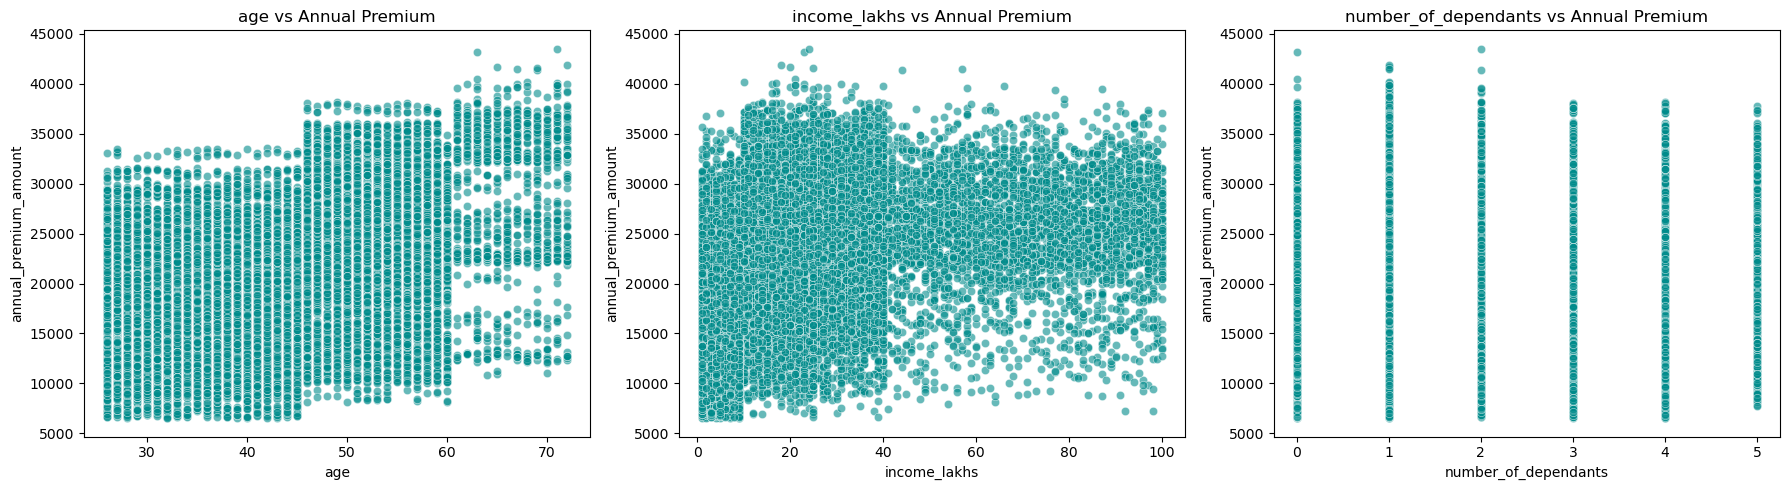

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

features = ['age', 'income_lakhs', 'number_of_dependants']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, col in zip(axes, features):
    sns.scatterplot(data=df2, x=col, y='annual_premium_amount', alpha=0.6, ax=ax, color='darkcyan')
    ax.set_title(f'{col} vs Annual Premium')

plt.tight_layout()
plt.show()


The plots show how annual insurance premium varies with age, income, and number of dependents.
Premiums tend to rise slightly with age, though with considerable spread.
Income shows no strong linear relationship with premium—values are widely scattered.
The number of dependents also doesn’t show a clear trend, indicating weak correlation with premium.

In [27]:
# getting the subcategories in the different category columns
categorical_cols = df2.select_dtypes(['object']).columns
for col in categorical_cols:
    print(col, df2[col].unique())

gender ['Male' 'Female']
region ['Northwest' 'Southeast' 'Northeast' 'Southwest']
marital_status ['Unmarried' 'Married']
bmi_category ['Normal' 'Obesity' 'Overweight' 'Underweight']
smoking_status ['No Smoking' 'Regular' 'Occasional' 'Does Not Smoke' 'Not Smoking'
 'Smoking=0']
employment_status ['Salaried' 'Self-Employed' 'Freelancer']
income_level ['<10L' '10L - 25L' '> 40L' '25L - 40L']
medical_history ['Diabetes' 'High blood pressure' 'No Disease'
 'Diabetes & High blood pressure' 'Thyroid' 'Heart disease'
 'High blood pressure & Heart disease' 'Diabetes & Thyroid'
 'Diabetes & Heart disease']
insurance_plan ['Bronze' 'Silver' 'Gold']


In [28]:
# Changing the different non-smoking categories to No Smoking 
df2['smoking_status'] = df2['smoking_status'].replace(
    {
        'Smoking=0': 'No Smoking',
        'Does Not Smoke': 'No Smoking',
        'Not Smoking': 'No Smoking'
    }
)
df2['smoking_status'].unique()

array(['No Smoking', 'Regular', 'Occasional'], dtype=object)

In [29]:
# getting the gender count
df2['gender'].value_counts()

gender
Male      16376
Female    13446
Name: count, dtype: int64

In [30]:
# percentage count of the gender values
pct_count = df2['gender'].value_counts(normalize=True)
pct_count

gender
Male      0.549125
Female    0.450875
Name: proportion, dtype: float64

In [31]:
# percentage count of the gender count
pct_count.values

array([0.54912481, 0.45087519])

<Axes: xlabel='gender'>

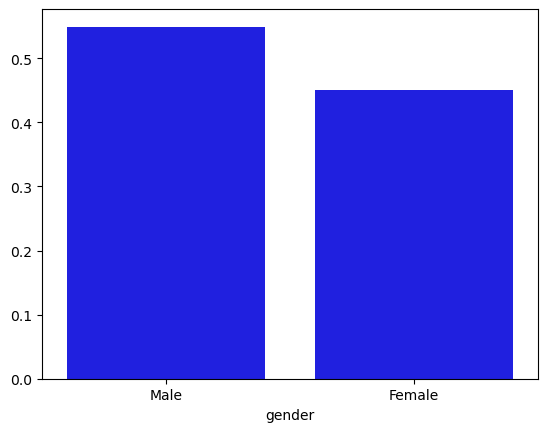

In [32]:
# Bar plotting of the gender percentage count
sns.barplot(x=pct_count.index, y=pct_count.values, color = 'blue')

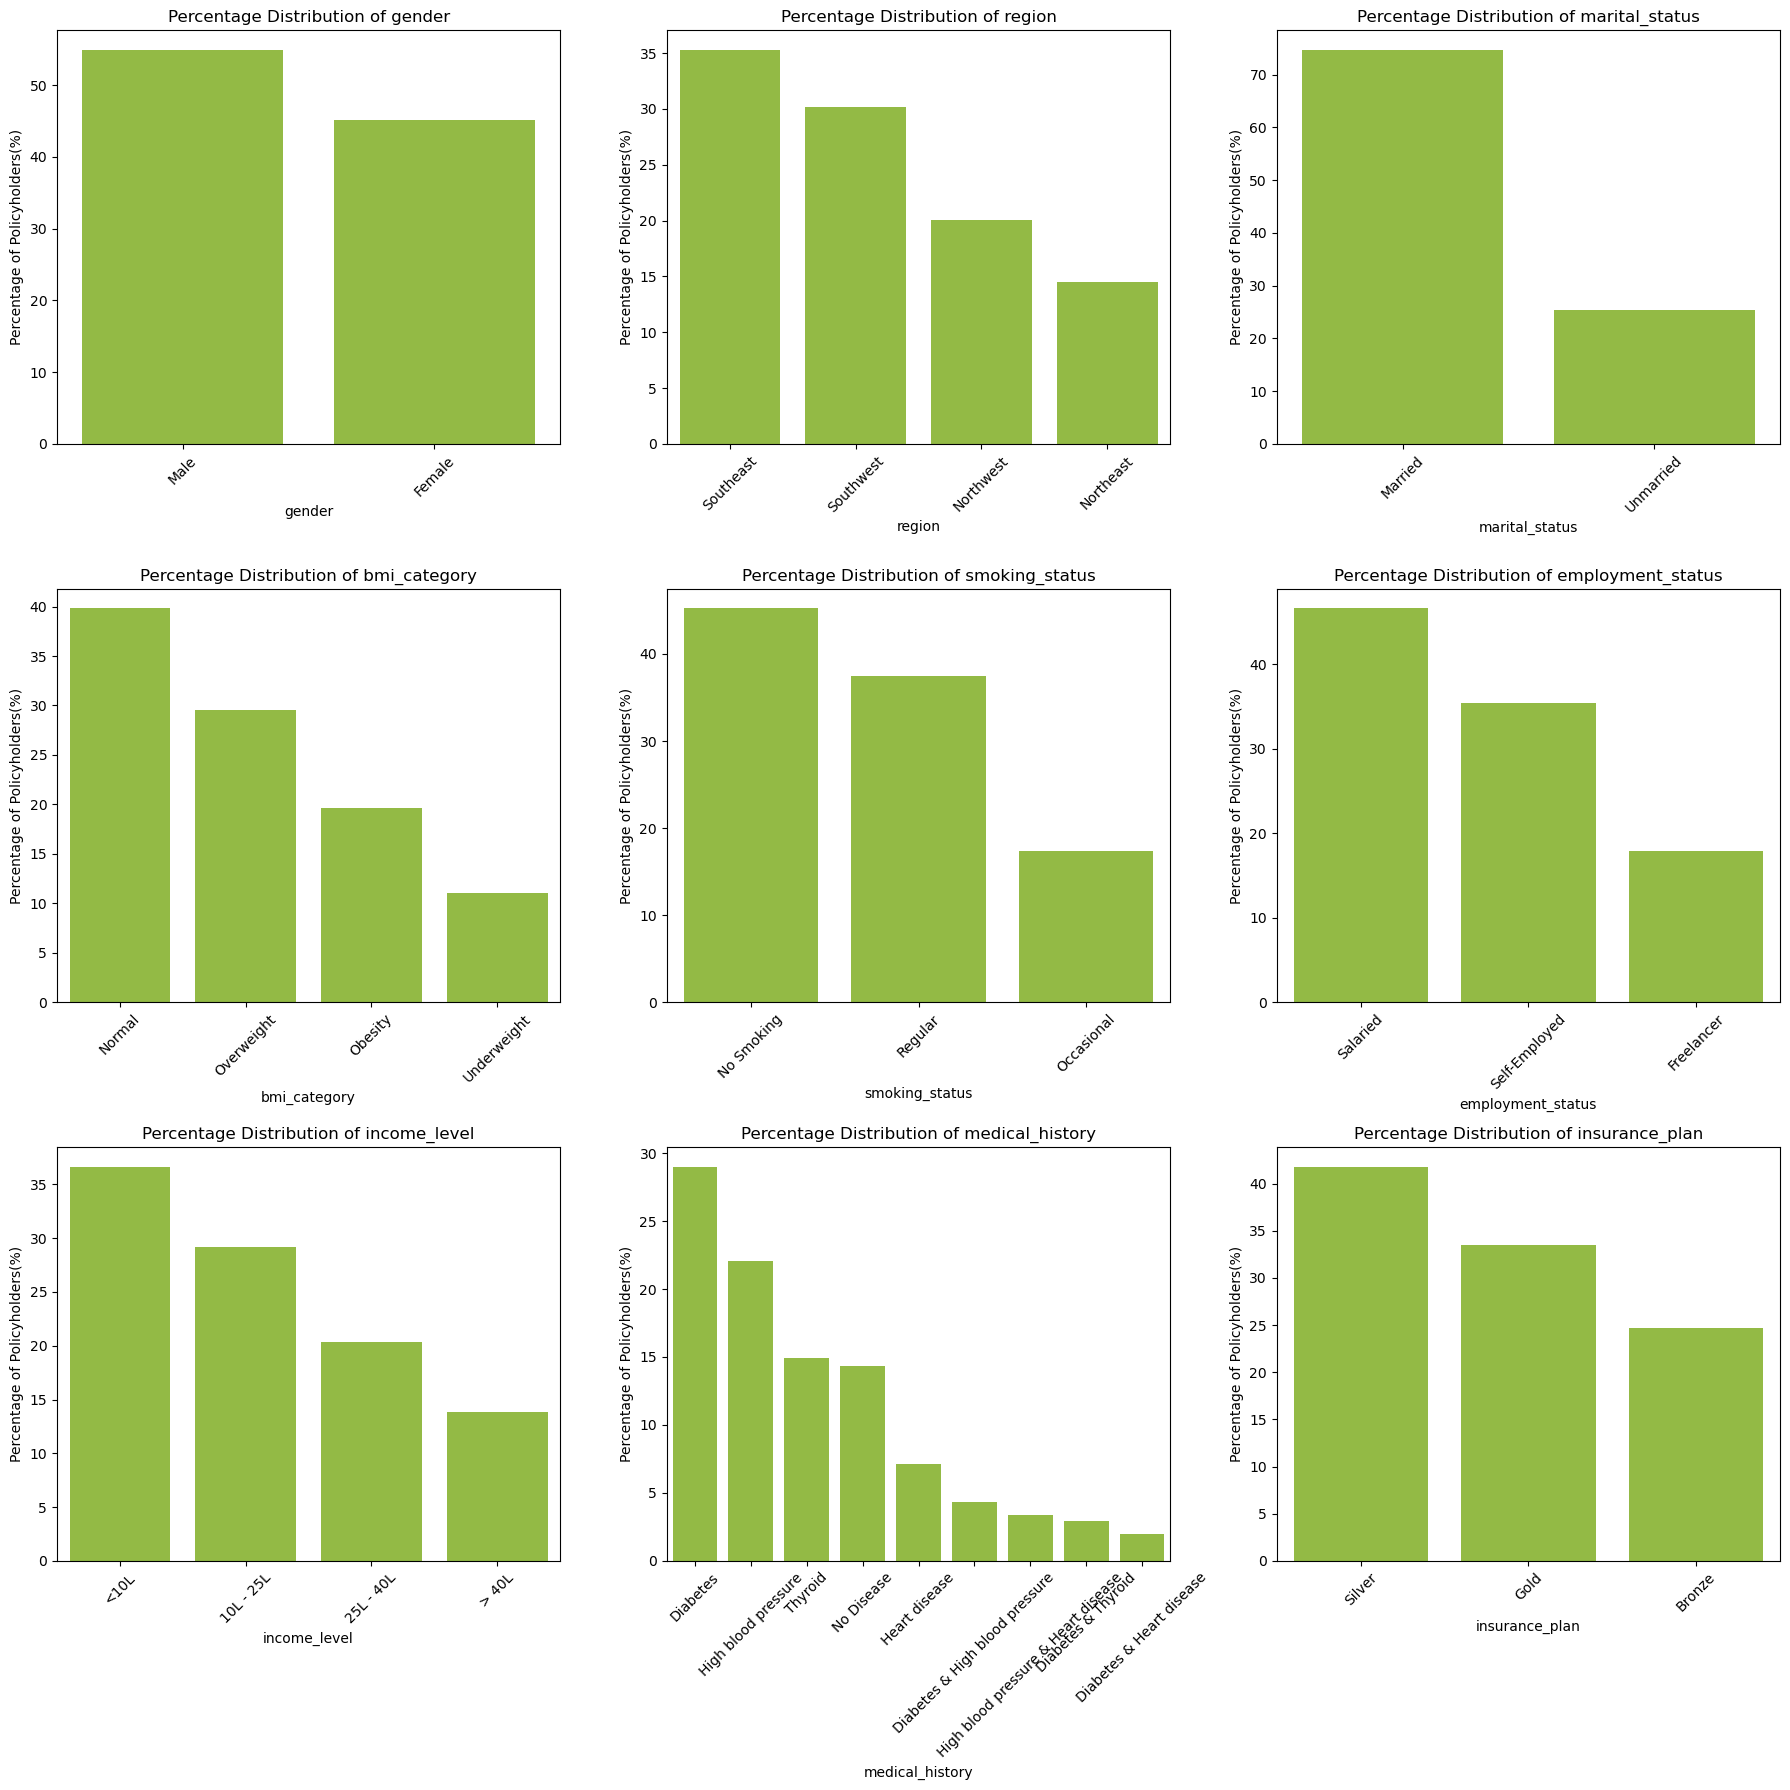

In [33]:
# Plotting percentage of policy holders w.r.t different categories
fig, axes = plt.subplots(3, 3, figsize=(18,18))  # Adjust figure size as necessary
axes = axes.flatten()  # Flatten the 2D array of axes into 1D for easier iteration

for ax, column in zip(axes, categorical_cols):
    # Calculate the percentage distribution of each category
    category_counts = df2[column].value_counts(normalize=True)*100  # normalize =True gives the relation

    # Plotting the distribution using barplot
    sns.barplot(x=category_counts.index, y=category_counts.values, ax=ax, color='yellowgreen')
    ax.set_title(f'Percentage Distribution of {column}')
    ax.set_ylabel('Percentage of Policyholders(%)')
    ax.set_label(column)     # Set xlabel to the column name for clarity

    # Rotate labels for better readability
    ax.tick_params(axis='x', rotation=45)
    
plt.tight_layout()   # Adjusts plot parameters for better fit in the figure window
plt.show()

The sample is slightly male-dominant, with males just above females.

Most participants come from the Southwest, followed by the Southeast.

Marital status is heavily skewed toward married individuals.

BMI distribution shows most are normal weight or overweight.

The majority are non-smokers, with fewer former or occasional smokers.

Employment is mostly full-time or self-employed, with fewer unemployed.

Income levels lean toward the < 25k and 25k–75k brackets.

Common medical histories include diabetes and hypertension.

Insurance plans are mostly basic, with fewer standard and premium users.

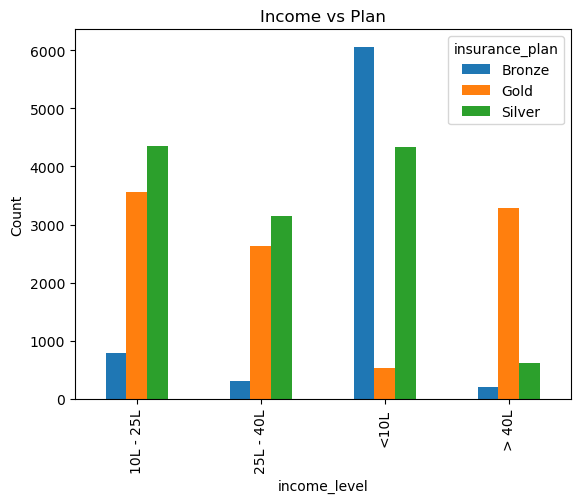

In [34]:
# plotting  the insurance_plan values as per income level
crosstab = pd.crosstab(df2['income_level'], df2['insurance_plan'])
crosstab
crosstab.plot(kind='bar')
plt.title('Income vs Plan')
plt.ylabel('Count')
plt.show()

The chart compares how many people in each income bracket choose different insurance plans.
Lower-income individuals (<10L) mostly opt for the Bronze plan, while middle-income groups (10L–40L) prefer Silver and Gold plans.
Higher-income individuals (>40L) primarily choose the Gold plan.
Overall, Silver and Gold dominate in mid-income ranges, while Bronze is most common for low income.

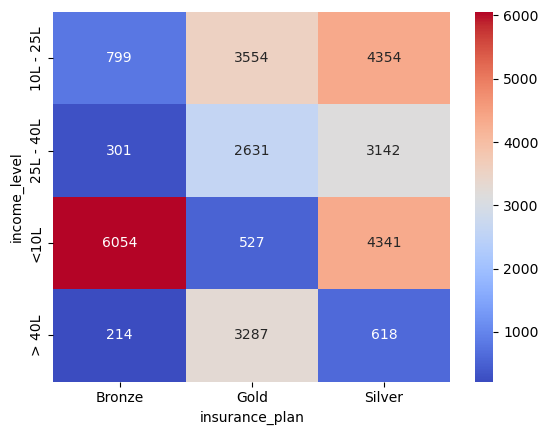

In [35]:
# Corrlation plot of income level and insurance plan
sns.heatmap(crosstab, annot=True, fmt='d', cmap='coolwarm')
plt.show()

People with <10L income overwhelmingly choose Bronze plans, while 10L–25L and 25L–40L groups lean more toward Gold and Silver.
Higher-income individuals (>40L) also prefer Gold, with fewer choosing Bronze or Silver.
Overall, affordability drives lower-income groups toward Bronze, while higher-income groups opt for higher-tier plans.

In [36]:
# Checking the data
df2.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,10L - 25L,14,Diabetes,Bronze,15610


In [37]:
# Getting the different categories of medical history
df2.medical_history.unique()

array(['Diabetes', 'High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Thyroid', 'Heart disease',
       'High blood pressure & Heart disease', 'Diabetes & Thyroid',
       'Diabetes & Heart disease'], dtype=object)

In [38]:
# Adding the risk score  for differenct medical category
risk_scores = {
    "diabetes": 6,
    "heart disease": 8,
    "high blood pressure": 6,
    "thyroid": 5,
    "no disease": 0,
    "none": 0
}

# Split medical_history into two columns
df2[['disease1', 'disease2']] = (
    df2['medical_history']
    .str.lower()               # convert entire string to lowercase
    .str.split("&", expand=True)
)

# Replace missing diseases with 'none'
df2['disease1'] = df2['disease1'].fillna('none').str.strip()
df2['disease2'] = df2['disease2'].fillna('none').str.strip()

df2.head()


,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,diabetes,none
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,diabetes,none
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,high blood pressure,none
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303,no disease,none
4,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,10L - 25L,14,Diabetes,Bronze,15610,diabetes,none


In [39]:
# Fill missing disease values
df2['disease1'] = df2['disease1'].fillna('none')
df2['disease2'] = df2['disease2'].fillna('none')

# Initialize total score
df2['total_risk_score'] = 0

# Add scores for each disease
for disease in ['disease1', 'disease2']:
    df2['total_risk_score'] += (
        df2[disease].map(risk_scores).fillna(0)
    )

# Normalize the risk score
max_score = df2['total_risk_score'].max()
min_score = df2['total_risk_score'].min()

if max_score != min_score:
    df2['normalized_risk_score'] = (
        (df2['total_risk_score'] - min_score) /
        (max_score - min_score)
    )
else:
    df2['normalized_risk_score'] = 0   # All scores identical → normalized = 0

df2.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,diabetes,none,6,0.428571
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,high blood pressure,none,6,0.428571
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303,no disease,none,0,0.000000
4,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,10L - 25L,14,Diabetes,Bronze,15610,diabetes,none,6,0.428571


In [40]:
# Getting the insurance plan calegory
df2.insurance_plan.unique()

array(['Bronze', 'Silver', 'Gold'], dtype=object)

In [41]:
# Mapping the Insurance Plan
df2['insurance_plan'] = df2['insurance_plan'].map({'Bronze':1, 'Silver':2, 'Gold':3})
df2.insurance_plan.unique()

array([1, 2, 3])

In [42]:
# Mapping the Income Level
df2['income_level'] = df2['income_level'].map({'<10L':1, '10L - 25L':2, '25L - 40L':3, '> 40L':4})
df2.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,1,6,Diabetes,1,9053,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,1,6,Diabetes,1,16339,diabetes,none,6,0.428571
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,2,20,High blood pressure,2,18164,high blood pressure,none,6,0.428571
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,4,77,No Disease,3,20303,no disease,none,0,0.000000
4,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,2,14,Diabetes,1,15610,diabetes,none,6,0.428571


In [43]:
# Getting dummies for nominal value columns
nominal_cols = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status','employment_status']
df3 = pd.get_dummies(df2, columns = nominal_cols, drop_first =True, dtype=int)
df3.head()

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,Diabetes,1,9053,diabetes,none,6,...,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,Diabetes,1,16339,diabetes,none,6,...,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,High blood pressure,2,18164,high blood pressure,none,6,...,0,0,0,0,0,0,0,0,0,1
3,30,3,4,77,No Disease,3,20303,no disease,none,0,...,1,0,0,0,0,0,0,0,1,0
4,56,3,2,14,Diabetes,1,15610,diabetes,none,6,...,0,0,0,1,0,0,1,0,0,1


In [44]:
# Dropping the columns
df4 = df3.drop(['medical_history', 'disease1', 'disease2', 'total_risk_score'], axis=1)
df4.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,1,9053,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,1,16339,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,2,18164,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,30,3,4,77,3,20303,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,56,3,2,14,1,15610,0.428571,1,0,0,0,0,1,0,0,1,0,0,1


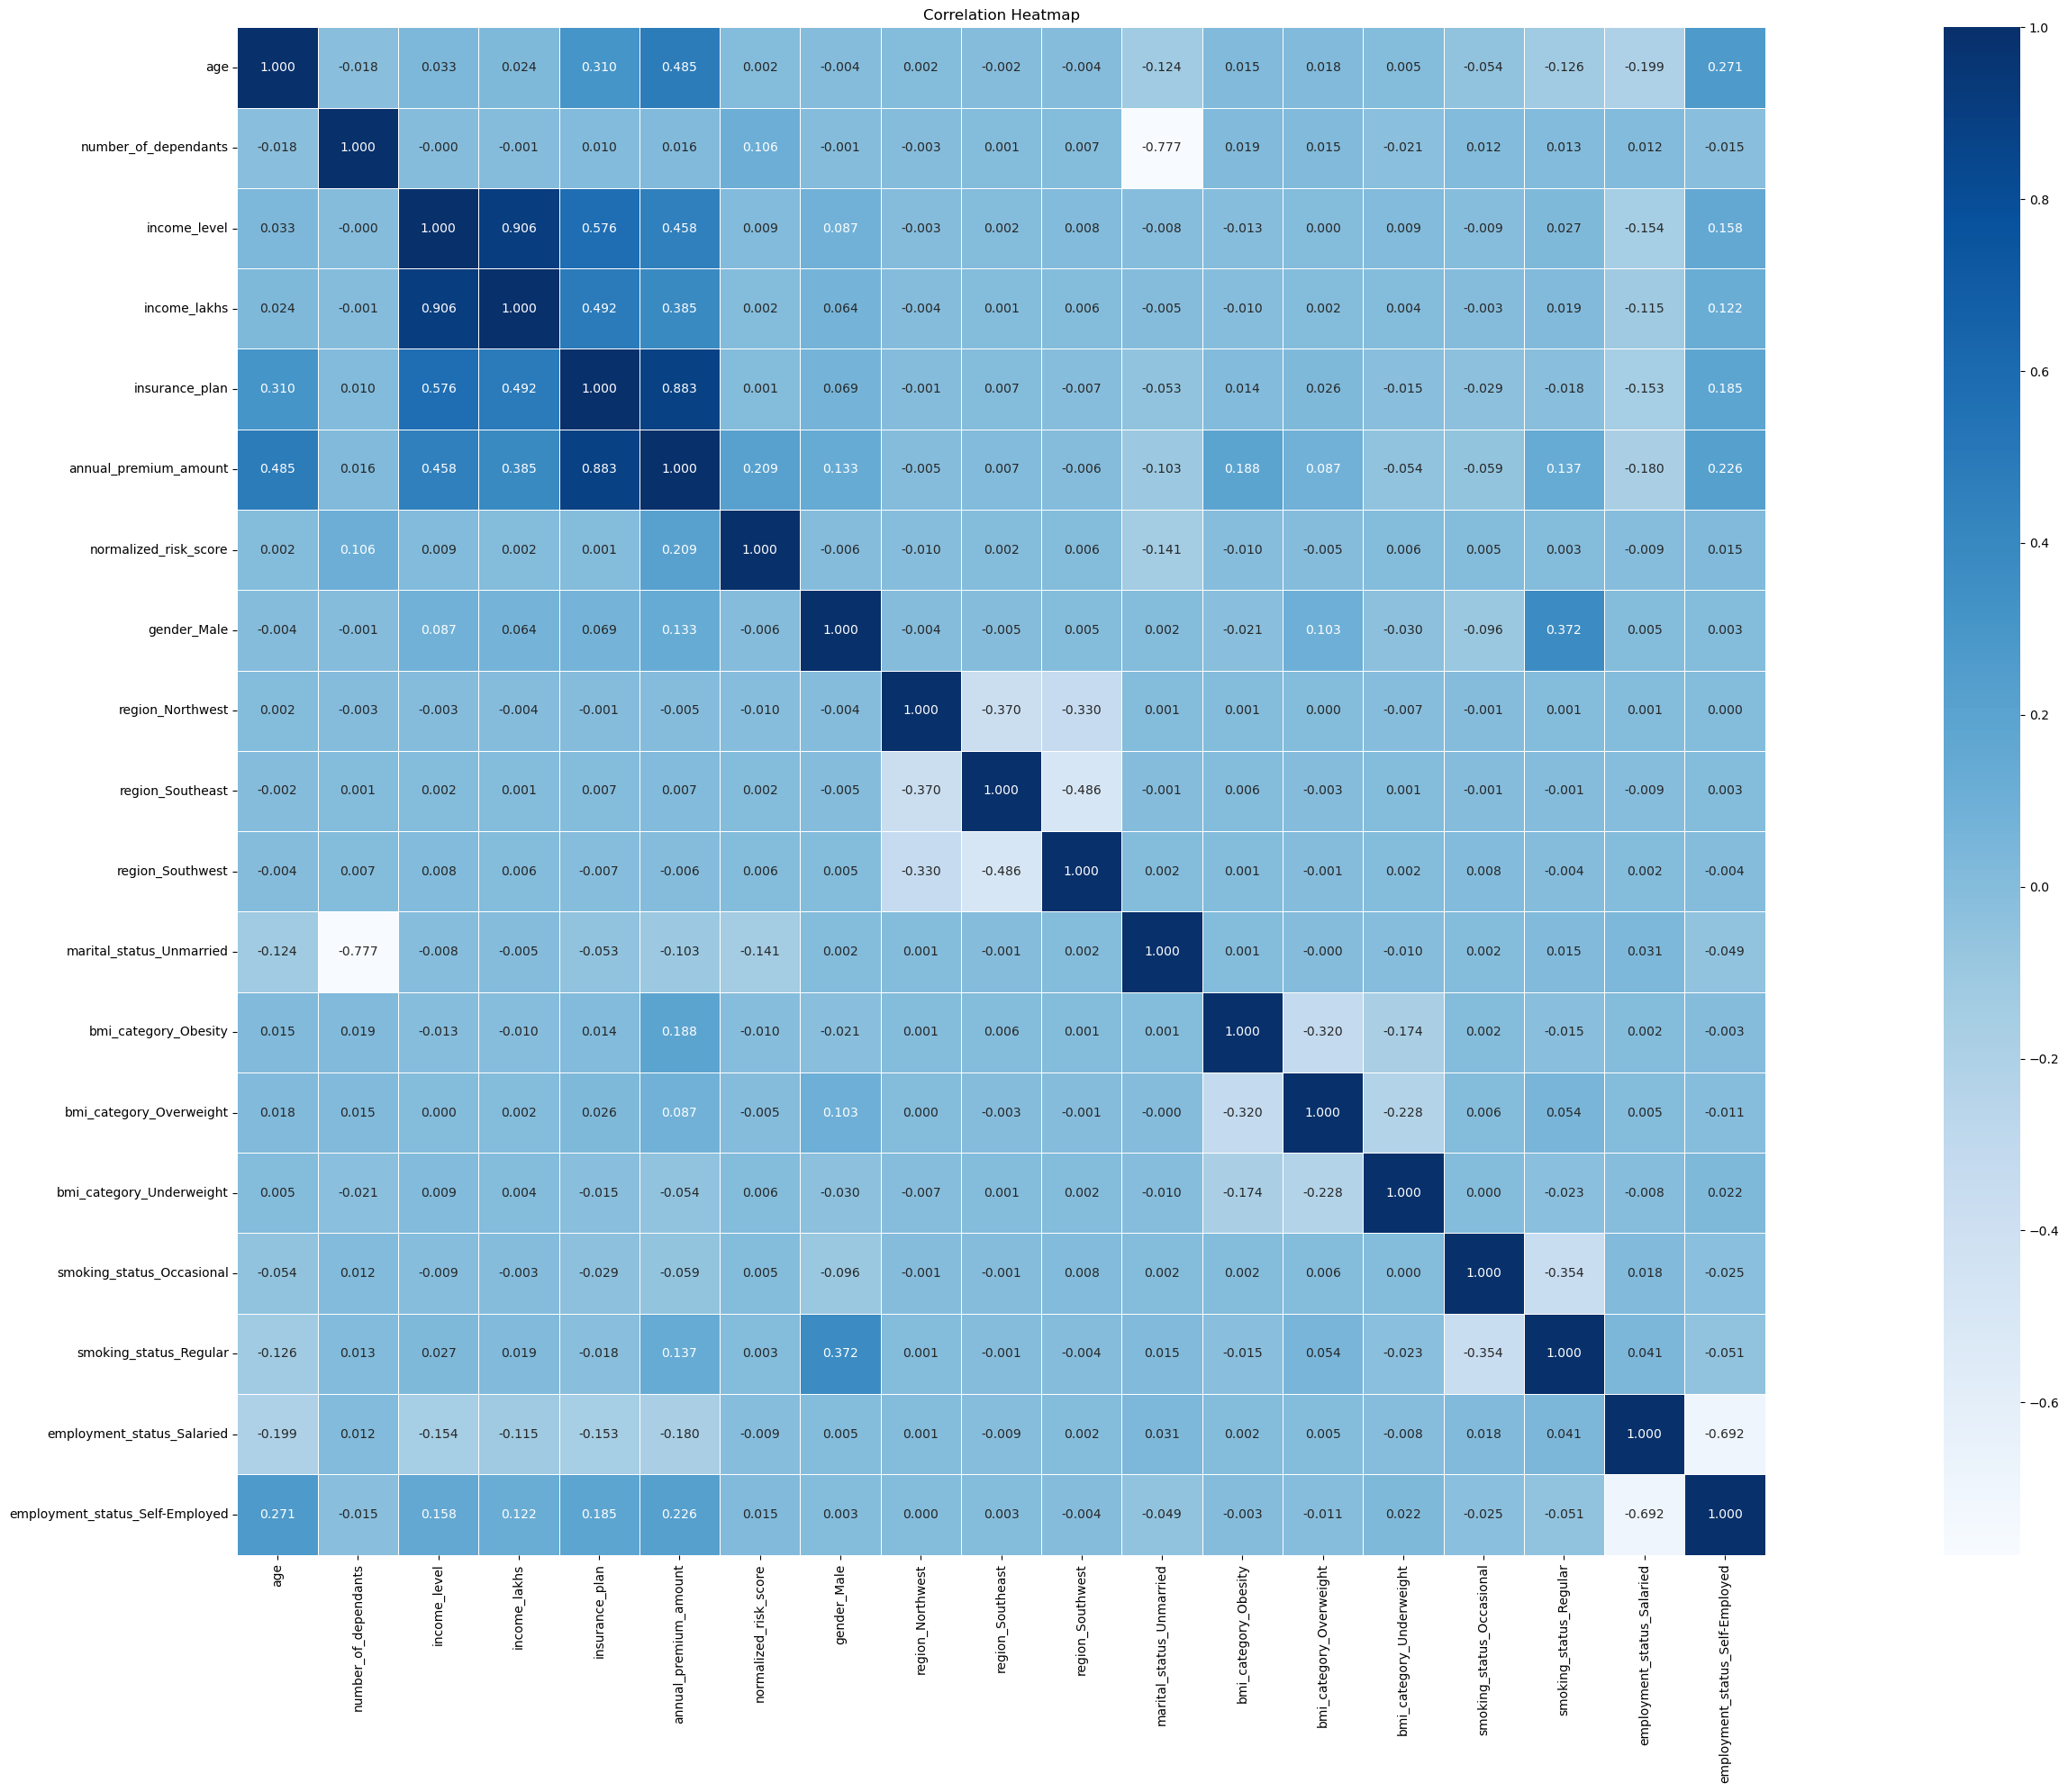

In [45]:
# Select only numeric columns for correlation
corr_matrix = df4.corr()

# Set up the matplotlib figure
plt.figure(figsize=(40, 20))

# Draw the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='Blues', fmt=".3f", linewidths=0.5, square=True)

plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

This correlation heatmap shows how different variables in the dataset relate to one another.
Most correlations are very weak, indicating minimal linear relationships across features.
A few stronger correlations appear, such as between income_level and income_in_lakhs, and between bmi_category groups (expected because they are related encodings).
Annual premium amount also has moderate positive correlation with income-related features.
Overall, the dataset does not exhibit strong multicollinearity, making it suitable for most predictive modeling methods.

In [46]:
# Scalling the necessary columns 
X = df4.drop('annual_premium_amount', axis='columns')
y= df4['annual_premium_amount']

from sklearn.preprocessing import MinMaxScaler
cols_to_scale = ['age', 'number_of_dependants','income_level', 'income_lakhs', 'insurance_plan']
scaler = MinMaxScaler()

X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])
X.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.000000,0.0,0.000000,0.050505,0.0,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,0.065217,0.4,0.000000,0.050505,0.0,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,0.500000,0.4,0.333333,0.191919,0.5,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,0.086957,0.6,1.000000,0.767677,1.0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,0.652174,0.6,0.333333,0.131313,0.0,0.428571,1,0,0,0,0,1,0,0,1,0,0,1


In [47]:
# Getting the more information
X.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
count,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000
mean,0.371628,0.477547,0.371225,0.224509,0.544112,0.426373,0.549125,0.200691,0.352693,0.301992,0.253336,0.196835,0.295051,0.110087,0.173228,0.374656,0.466132,0.354269
std,0.240053,0.284129,0.351111,0.226822,0.379009,0.240084,0.497589,0.400524,0.477816,0.459129,0.434929,0.397613,0.456073,0.313003,0.378450,0.484042,0.498860,0.478299
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.173913,0.200000,0.000000,0.060606,0.500000,0.357143,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.347826,0.600000,0.333333,0.161616,0.500000,0.428571,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.565217,0.600000,0.666667,0.313131,1.000000,0.428571,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [48]:
# Calculate the Vif score
def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df['Column']= data.columns
    vif_df['VIF']= [variance_inflation_factor(data.values,i) for i in range(data.shape[1])]
    return vif_df

In [49]:
calculate_vif(X)

,Column,VIF
0,age,3.921783
1,number_of_dependants,6.278938
2,income_level,13.890522
3,income_lakhs,11.185596
4,insurance_plan,5.271297
5,normalized_risk_score,3.810619
6,gender_Male,2.599098
7,region_Northwest,2.123965
8,region_Southeast,2.980842
9,region_Southwest,2.710097


The VIF table checks multicollinearity among your model’s features. Most variables have acceptable VIF values (below 5), indicating low to moderate correlation. However, income_level and income_lakhs have very high VIF (>10), showing severe multicollinearity.

In [50]:
# Dropping the income_level
calculate_vif(X.drop('income_level', axis ='columns'))

,Column,VIF
0,age,3.863055
1,number_of_dependants,6.278147
2,income_lakhs,2.678102
3,insurance_plan,4.574625
4,normalized_risk_score,3.808345
5,gender_Male,2.591439
6,region_Northwest,2.123277
7,region_Southeast,2.979899
8,region_Southwest,2.708641
9,marital_status_Unmarried,2.345757


On dropping the income level, the VIF values are within acceptable limit.

In [51]:
# creating new dataset after dropping the income level
X_reduced = X.drop('income_level', axis='columns')
X_reduced.head()

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.000000,0.0,0.050505,0.0,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,0.065217,0.4,0.050505,0.0,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,0.500000,0.4,0.191919,0.5,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,0.086957,0.6,0.767677,1.0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,0.652174,0.6,0.131313,0.0,0.428571,1,0,0,0,0,1,0,0,1,0,0,1


## Model Training

In [52]:
# Importing the train_test_split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, random_state=10)

print('X_train:', X_train.shape)
print('X_test:', X_test.shape)
print('y_train:', X_train.shape)
print('y_test:', y_test.shape)

X_train: (20875, 17)
X_test: (8947, 17)
y_train: (20875, 17)
y_test: (8947,)


### Using Linear Regression

In [53]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
train_score = model_lr.score(X_train, y_train)
test_score = model_lr.score(X_test, y_test)
train_score, test_score

(0.9534163989489616, 0.9538448451629948)

In [54]:
# making the prediction
y_preds = model_lr.predict(X_test)

mse_lr = mean_squared_error(y_test, y_preds)
rmse_lr = np.sqrt(mse_lr)
print("XGBoost Regression ==> MSE:", mse_lr, "RMSE: ", rmse_lr)

XGBoost Regression ==> MSE: 2183844.360312455 RMSE:  1477.7835972538248


In [55]:
# model coefficients
model_lr.coef_

array([ 7016.2393283 , -1311.76470171,  -708.19336921, 14835.98820801,
        6053.6241234 ,    37.55826883,   -55.25087215,   -19.62254288,
         -22.28967559,  -700.32019985,  3926.8127061 ,  1979.45604663,
         612.86623617,   837.3951011 ,  2800.66184334,   -45.49136706,
         243.07842087])

In [56]:
# X test columns
X_test.columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'insurance_plan',
       'normalized_risk_score', 'gender_Male', 'region_Northwest',
       'region_Southeast', 'region_Southwest', 'marital_status_Unmarried',
       'bmi_category_Obesity', 'bmi_category_Overweight',
       'bmi_category_Underweight', 'smoking_status_Occasional',
       'smoking_status_Regular', 'employment_status_Salaried',
       'employment_status_Self-Employed'],
      dtype='object')

In [57]:
# creating the dataset for the features
feature_importances = model_lr.coef_

coef_df = pd.DataFrame(feature_importances, index=X_test.columns, columns=['Coefficients'])
coef_df

,Coefficients
age,7016.239328
number_of_dependants,-1311.764702
income_lakhs,-708.193369
insurance_plan,14835.988208
normalized_risk_score,6053.624123
gender_Male,37.558269
region_Northwest,-55.250872
region_Southeast,-19.622543
region_Southwest,-22.289676
marital_status_Unmarried,-700.320200


In [58]:
# sorting the feature importance
coef_df = coef_df.sort_values(by = 'Coefficients', ascending=True)
coef_df

,Coefficients
number_of_dependants,-1311.764702
income_lakhs,-708.193369
marital_status_Unmarried,-700.320200
region_Northwest,-55.250872
employment_status_Salaried,-45.491367
region_Southwest,-22.289676
region_Southeast,-19.622543
gender_Male,37.558269
employment_status_Self-Employed,243.078421
bmi_category_Underweight,612.866236


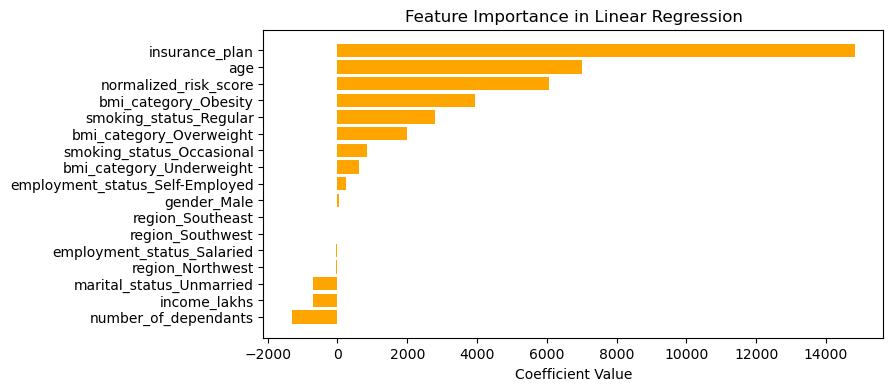

In [59]:
# plotting the feature importance values
plt.figure(figsize=(8,4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='orange')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Linear Regression')
plt.show()

The bar chart shows the coefficients from a linear regression model, indicating how strongly each feature influences the predicted outcome.
Insurance plan, age, and risk score have the largest positive effects, meaning they drive predictions upward the most.
BMI categories and smoking status also contribute moderately, while income and number of dependents have small or slightly negative effects.

## Using Ridge model

In [60]:
model_rg = Ridge()
model_rg.fit(X_train, y_train)
train_score = model_rg.score(X_train, y_train)
test_score = model_rg.score(X_test, y_test)
train_score, test_score

(0.9534162332209687, 0.9538456995663842)

## Using XGBoost model

In [61]:
from xgboost import XGBRegressor
model_xgb = XGBRegressor()
model_xgb.fit(X_train, y_train)
train_score = model_xgb.score(X_train, y_train)
test_score = model_xgb.score(X_test, y_test)
train_score, test_score

(0.9986370801925659, 0.9979538321495056)

It is clear that XGBoost gives highest model score. 

In [62]:
# making the prediction 
y_preds = model_xgb.predict(X_test)

mse_xgb = mean_squared_error(y_test, y_preds)
rmse_xgb = np.sqrt(mse_xgb)
print("XGBoost Regression ==> MSE:", mse_xgb, "RMSE: ", rmse_xgb)

XGBoost Regression ==> MSE: 96814.21540071907 RMSE:  311.14982789762087


## Randomized SearchCV

In [63]:
# Using Randomized SearchCV
model_xgb = XGBRegressor()
param_grid = {
    'n_estimators': [20, 40, 50],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
}
random_search = RandomizedSearchCV(model_xgb, param_grid, n_iter=10, cv=3, scoring='r2', random_state=42)
random_search.fit(X_train, y_train)
random_search.best_score_

0.9970577955245972

In [64]:
# Finding best parameters
random_search.best_params_

{'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1}

In [65]:
# best model
best_model = random_search.best_estimator_

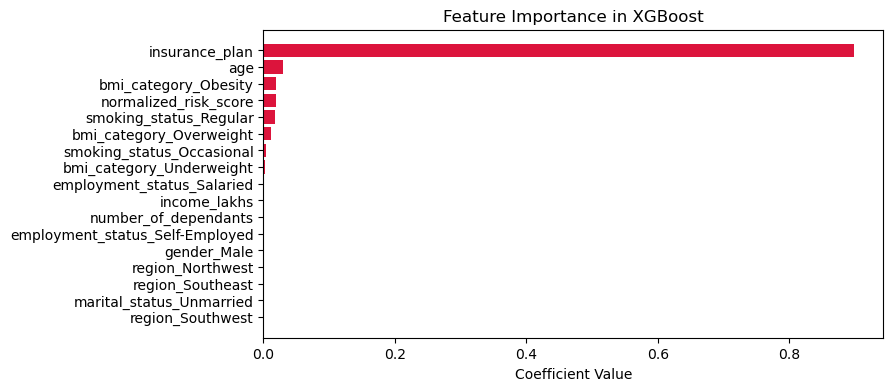

In [66]:
# Plotting the feature importance
feature_importances = best_model.feature_importances_
coef_df = pd.DataFrame(feature_importances, index=X_test.columns, columns=['Coefficients'])
coef_df = coef_df.sort_values(by= 'Coefficients', ascending=True)

plt.figure(figsize=(8,4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='crimson')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in XGBoost')
plt.show()

### Error Analysis

In [67]:
# Conducting  Error Analysis
y_preds = best_model.predict(X_test)

residuals = y_preds - y_test
residuals_pct = residuals*100/ y_test

results_df = pd.DataFrame({
    'actual': y_test,
    'predicted': y_preds,
    'diff' : residuals,
    'diff_pct': residuals_pct

})
results_df.head()

,actual,predicted,diff,diff_pct
19713,26895,26691.470703,-203.529297,-0.756755
14750,22734,22650.751953,-83.248047,-0.366183
19932,21198,21581.894531,383.894531,1.810994
29643,9100,9425.934570,325.934570,3.581699
17076,26434,26691.470703,257.470703,0.974013


<Axes: xlabel='diff_pct', ylabel='Count'>

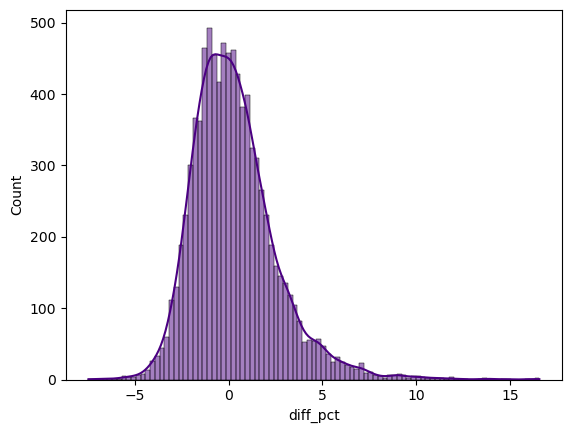

In [68]:
# Plotting the error percentage
sns.histplot(results_df['diff_pct'], kde=True, color='indigo')

This histogram shows the distribution of the variable **diff_pct**, with a smooth KDE curve overlaid.
The data are roughly centered near zero but skewed to the right, indicating more extreme positive values.
Most observations fall between about –3% and +4%, with fewer occurrences in the tails.

In [69]:
# Finding the rows where diff_pct greater than extreme error threshold
extreme_error_threshold = 10

extreme_results_df = results_df[np.abs(results_df.diff_pct)>extreme_error_threshold]
extreme_results_df.shape

(29, 4)

In [70]:
# Finding extreme_errors_pct
extreme_errors_pct = extreme_results_df.shape[0]*100/results_df.shape[0]
extreme_errors_pct

0.32413099362914943

In [71]:
# Finding the rows where Difference_pct > 50 percentage
results_df[np.abs(results_df.diff_pct)>50]

,actual,predicted,diff,diff_pct


In [72]:
# Sorting the diff_pct values
results_df[np.abs(results_df.diff_pct)>50].sort_values('diff_pct', ascending=False)

,actual,predicted,diff,diff_pct


In [73]:
# Getting the index value
X_test.index

Index([19713, 14750, 19932, 29643, 17076, 20314, 24893, 26722, 25844, 10731,
       ...
       10637,  1224, 17046, 19228,  9275,  3387,  7858,  9744,  4849,  8986],
      dtype='int64', length=8947)

In [74]:
# finding extreme results index
extreme_results_df.index

Index([14286, 27518,  9285,  7547, 21910, 12189, 21141, 16263,  8216, 13973,
        9150, 24145, 18522,  6163, 18681, 19145, 21455, 22666,  7508, 10741,
        6517, 18834, 13744, 24119,  2695, 25658, 11019, 14037,  7654],
      dtype='int64')

In [75]:
# extreme errors data
extreme_errors_df = X_test.loc[extreme_results_df.index]
extreme_errors_df.head()

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
14286,0.021739,0.6,0.050505,0.0,0.000000,1,1,0,0,1,0,0,0,0,0,1,0
27518,0.304348,0.6,0.080808,0.0,0.357143,1,1,0,0,0,0,0,0,0,0,0,1
9285,0.326087,0.6,0.010101,0.0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
7547,0.347826,0.2,0.080808,0.0,0.000000,1,0,1,0,1,0,0,0,0,0,1,0
21910,0.043478,0.6,0.020202,0.0,0.000000,1,0,1,0,0,0,0,0,0,0,0,0


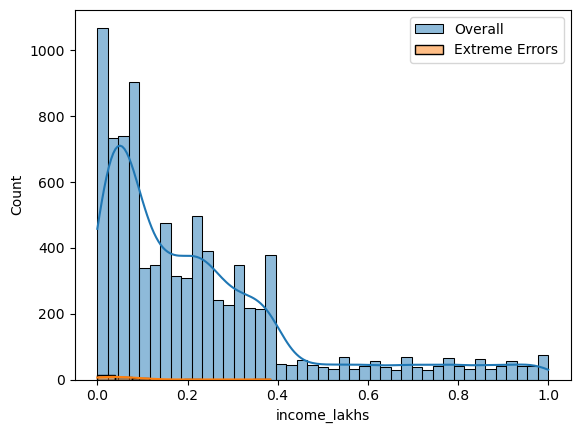

In [76]:
# plotting overall and extreme errors
sns.histplot(X_test.income_lakhs, label = "Overall", kde=True)
sns.histplot(extreme_errors_df.income_lakhs, label = "Extreme Errors", kde=True)
plt.legend()
plt.show()

The plot shows the overall income distribution (in lakhs) heavily concentrated at the lower end, tapering off as income increases.
Extreme-error cases (in orange) occur sparsely across the range, indicating they are rare and not tied to any specific income band.

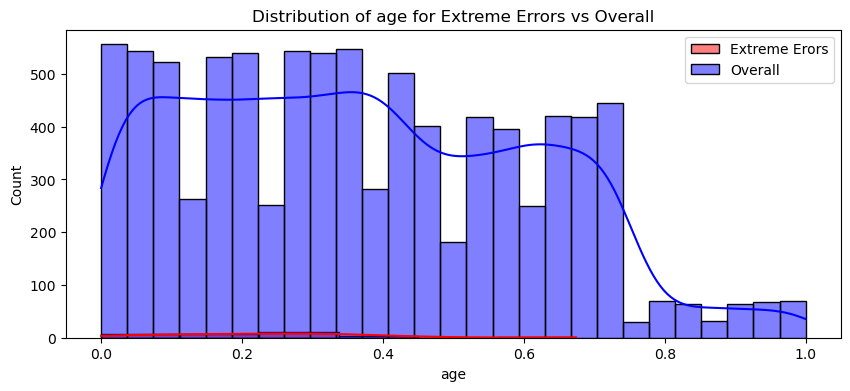

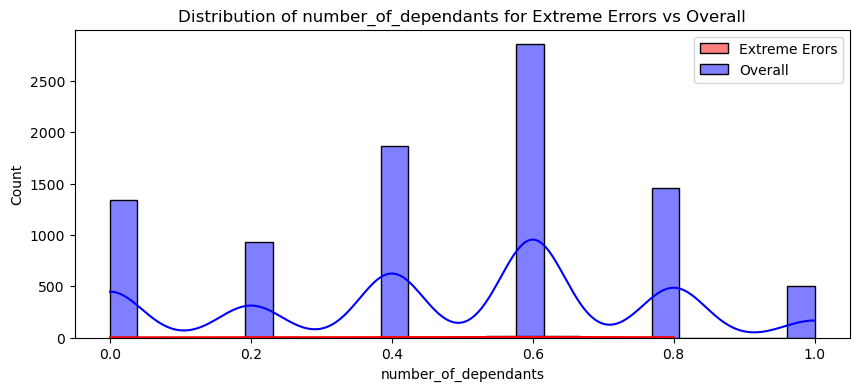

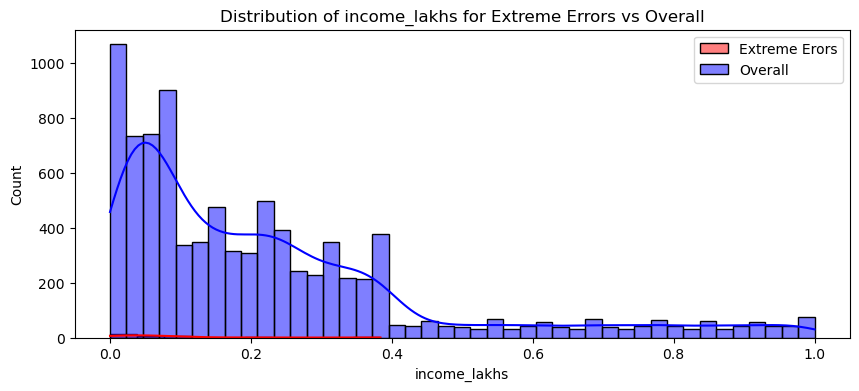

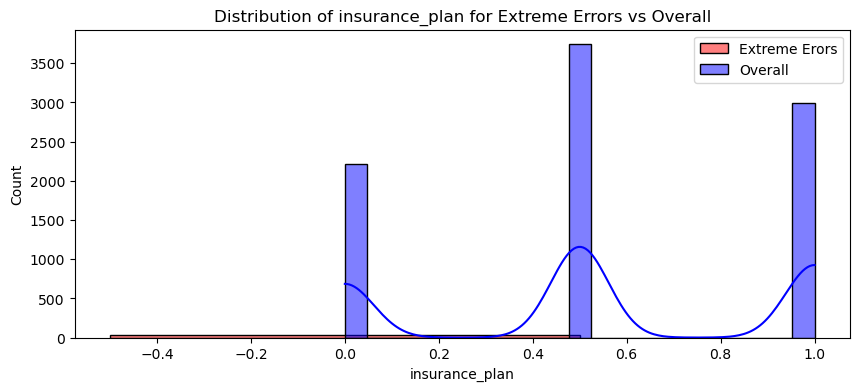

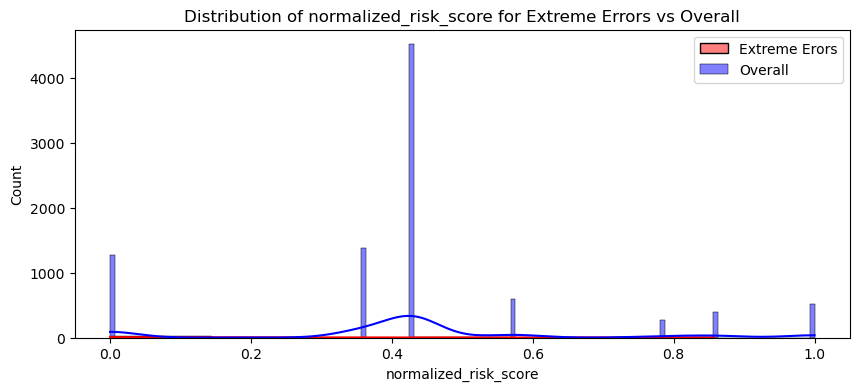

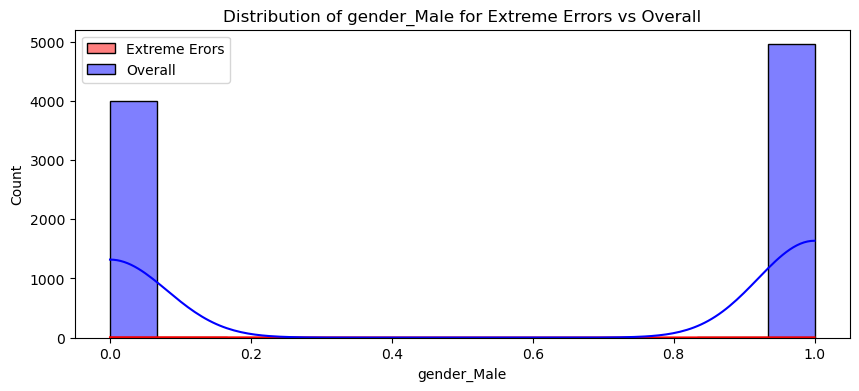

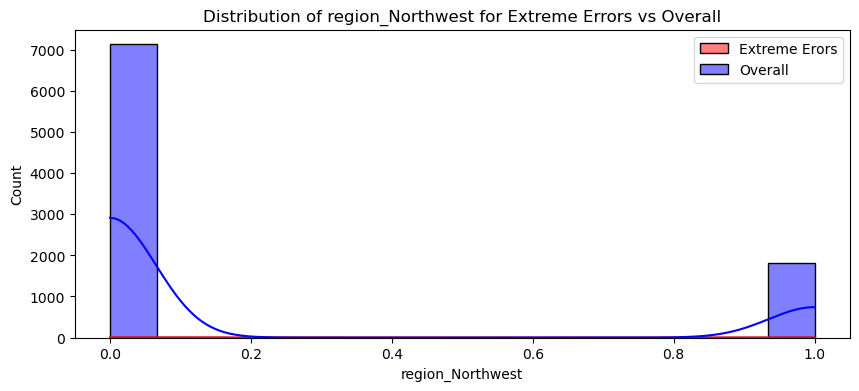

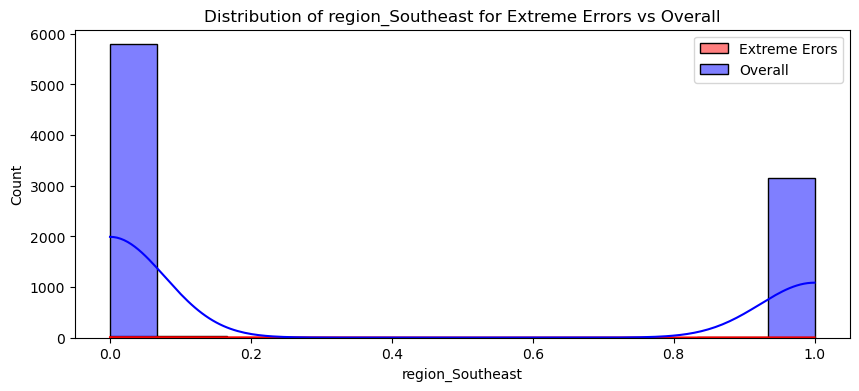

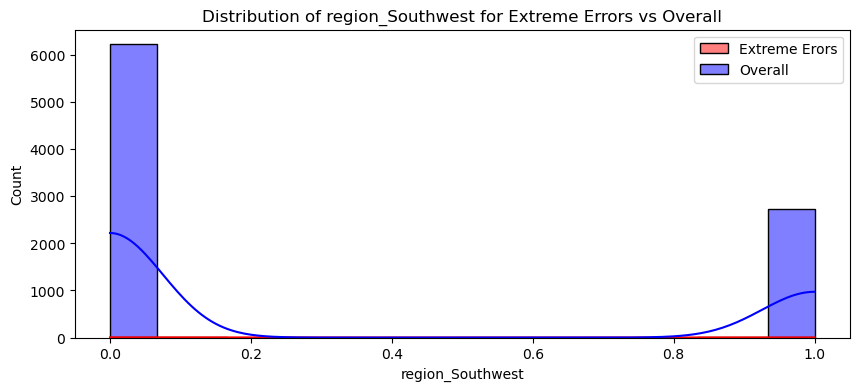

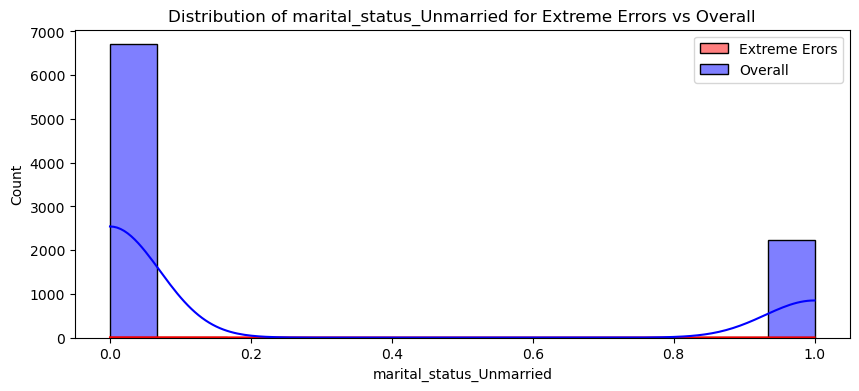

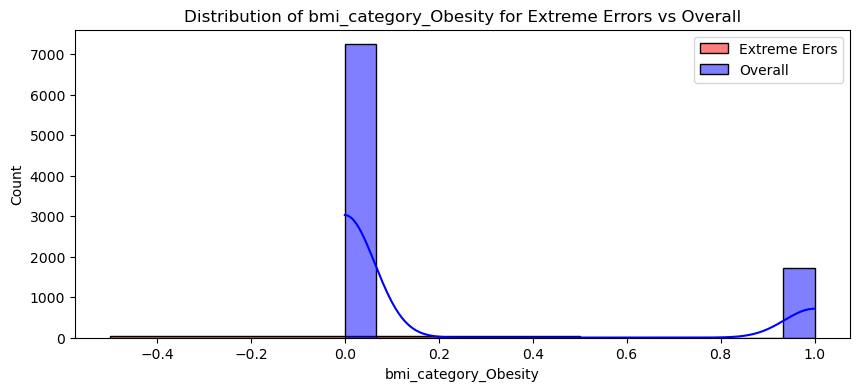

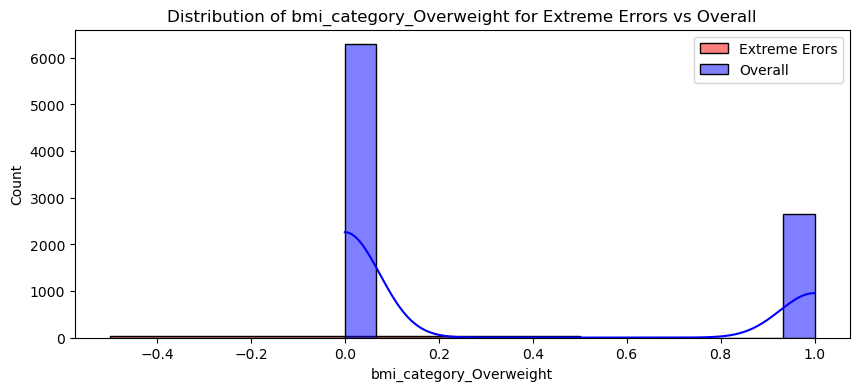

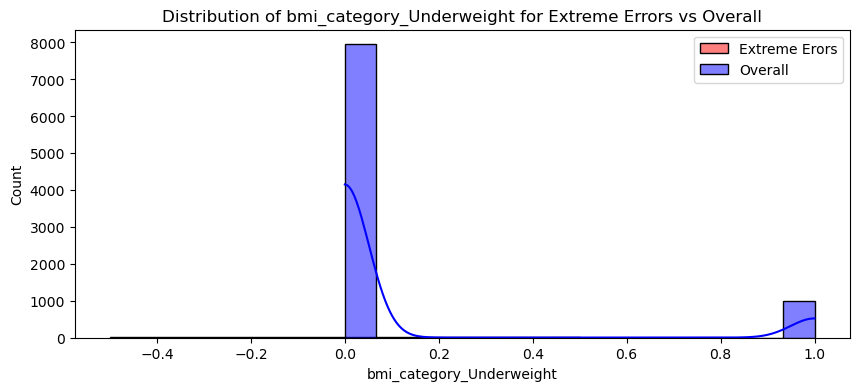

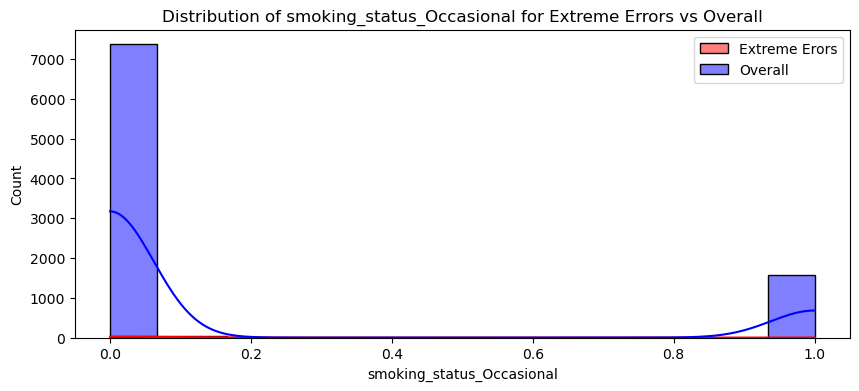

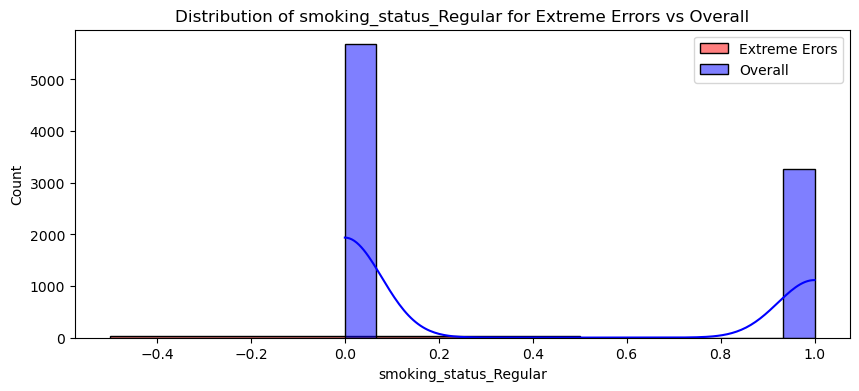

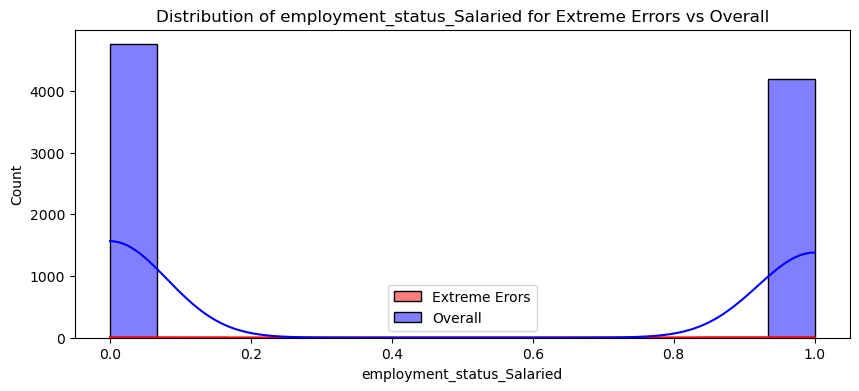

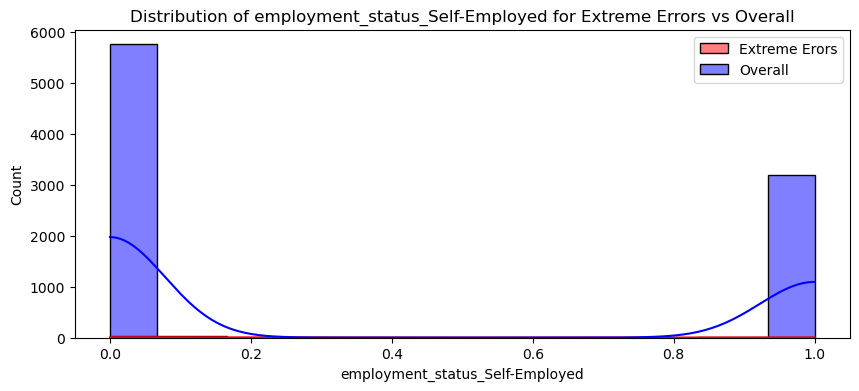

In [77]:
for feature in X_test.columns:
    plt.figure(figsize=(10,4))
    sns.histplot(extreme_errors_df[feature], color='red', label ='Extreme Erors', kde= True)
    sns.histplot(X_test[feature], color='blue', label ='Overall', alpha =0.5, kde= True)
    plt.legend()
    plt.title(f'Distribution of {feature} for Extreme Errors vs Overall')
    plt.show()

In [78]:
# columns to scale
cols_to_scale

['age',
 'number_of_dependants',
 'income_level',
 'income_lakhs',
 'insurance_plan']

In [79]:
extreme_errors_df['income_level']=-1

In [80]:
df_reversed = pd.DataFrame()
df_reversed[cols_to_scale]=scaler.inverse_transform(extreme_errors_df[cols_to_scale])
df_reversed.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan
0,27.0,3.0,-2.0,6.0,1.0
1,40.0,3.0,-2.0,9.0,1.0
2,41.0,3.0,-2.0,2.0,1.0
3,42.0,1.0,-2.0,9.0,1.0
4,28.0,3.0,-2.0,3.0,1.0


In [81]:
df_reversed.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan
count,29.000000,29.000000,29.0,29.000000,29.0
mean,36.586207,2.241379,-2.0,6.862069,1.0
std,6.811321,1.184880,0.0,7.619168,0.0
min,26.000000,0.000000,-2.0,1.000000,1.0
25%,32.000000,1.000000,-2.0,3.000000,1.0
50%,37.000000,3.000000,-2.0,5.000000,1.0
75%,40.000000,3.000000,-2.0,9.000000,1.0
max,57.000000,4.000000,-2.0,39.000000,1.0


<Axes: xlabel='age', ylabel='Count'>

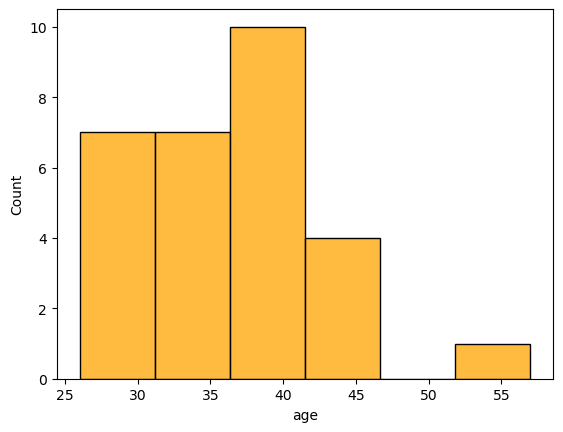

In [82]:
sns.histplot(df_reversed['age'],  color='orange')

In [83]:
df_reversed['age'].quantile(0.97)

47.760000000000005

For the dataset where age > 25, the XGBoost model achieved an excellent score with minimal error distribution. Therefore, XGBoost is the preferred model for making predictions on this subset.

## Summary

This analysis demonstrates that healthcare insurance premiums for individuals aged above 25 can be predicted with high accuracy using machine learning models, particularly XGBoost. After rigorous preprocessing and feature engineering, the XGBoost model significantly outperformed linear models, achieving an excellent test score with a low RMSE and minimal extreme prediction errors.

Key drivers of premium amounts include insurance plan type, age, normalized medical risk score, BMI category, and smoking status, while income and number of dependents showed weaker or indirect influence. Multicollinearity between income-related features was successfully addressed, improving model stability and interpretability.

Error analysis revealed that extreme prediction errors were rare (less than 0.5%) and not concentrated within any specific income or demographic group, indicating strong model generalization. Overall, this study validates XGBoost as the preferred model for premium prediction in the adult segment and provides actionable insights into the factors most strongly associated with healthcare insurance pricing.